In [2]:
#load data from the web later
library(tidyverse)
library(dplyr)
library(repr)
library(tidymodels)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

In [4]:
players <- read_csv("players.csv")

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Can we predict whether a player subscribes to the server’s email newsletter using their age, self-reported gender, and total hours played on the Minecraft research server?

In [43]:
players_clean <- players|>
        mutate(
            subscribe = as.factor(subscribe),
           experience = case_when(
                experience == "Beginner" ~ 1,
               experience == "Amateur" ~ 2,
               experience == "Regular" ~ 3,
               experience == "Veteran" ~ 4,
               experience == "Pro" ~ 5),
            gender = case_when(
                gender == "Male" ~ 1,
                gender == "Female" ~ 2,
                TRUE ~ 3)
            )|>
        drop_na()
players_clean

experience,subscribe,hashedEmail,played_hours,name,gender,Age
<dbl>,<fct>,<chr>,<dbl>,<chr>,<dbl>,<dbl>
5,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,1,9
4,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,1,17
4,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,1,17
2,TRUE,23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,0.7,Flora,2,21
3,TRUE,7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e,0.1,Kylie,1,21
2,TRUE,f58aad5996a435f16b0284a3b267f973f9af99e7a89bee0430055a44fa92f977,0.0,Adrian,2,17
3,TRUE,8e594b8953193b26f498db95a508b03c6fe1c24bb5251d392c18a0da9a722807,0.0,Luna,2,19
2,FALSE,1d2371d8a35c8831034b25bda8764539ab7db0f63938696917c447128a2540dd,0.0,Emerson,1,21
2,TRUE,8b71f4d66a38389b7528bb38ba6eb71157733df7d1740371852a797ae97d82d1,0.1,Natalie,1,47


In [44]:
set.seed(3456)
player_split <- initial_split(players_clean, prop = 0.75, strata = subscribe)  
player_train <- training(player_split)   
player_test <- testing(player_split)

In [51]:
options(warn = -1)
player_recipe <- recipe(subscribe ~ Age + played_hours + gender , data = player_train) |>
step_dummy(all_nominal_predictors())|>
step_scale(all_predictors()) |>
step_center(all_predictors())
player_recipe #can do upsampling to deal with class imbalance ch5.7.2

knn_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn")|>
    set_mode("classification")

player_vfold <- vfold_cv(player_train, v = 5, strata = subscribe)

k_vals <- tibble(neighbors = seq(from = 1, to = 50, by = 5)) 


#need to find best k first
#player_test_predictions <- predict(player_fit , player_test) |>
       #bind_cols(fruit_test)
#player_test_predictions

#then make conf mat



── Recipe ──────────────────────────────────────────────────────────────────────



── Inputs 

Number of variables by role

outcome:   1
predictor: 3



── Operations 

• Dummy variables from: all_nominal_predictors()

• Scaling for: all_predictors()

• Centering for: all_predictors()



neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.4337274,5,0.022319590,Preprocessor1_Model01
1,roc_auc,binary,0.4170455,5,0.025545138,Preprocessor1_Model01
6,accuracy,binary,0.6914122,5,0.044502433,Preprocessor1_Model02
6,roc_auc,binary,0.4894403,5,0.025691480,Preprocessor1_Model02
11,accuracy,binary,0.7525452,5,0.022576653,Preprocessor1_Model03
11,roc_auc,binary,0.5177373,5,0.041001270,Preprocessor1_Model03
16,accuracy,binary,0.7449425,5,0.012933461,Preprocessor1_Model04
16,roc_auc,binary,0.5245323,5,0.032073552,Preprocessor1_Model04
21,accuracy,binary,0.7316256,5,0.014307271,Preprocessor1_Model05


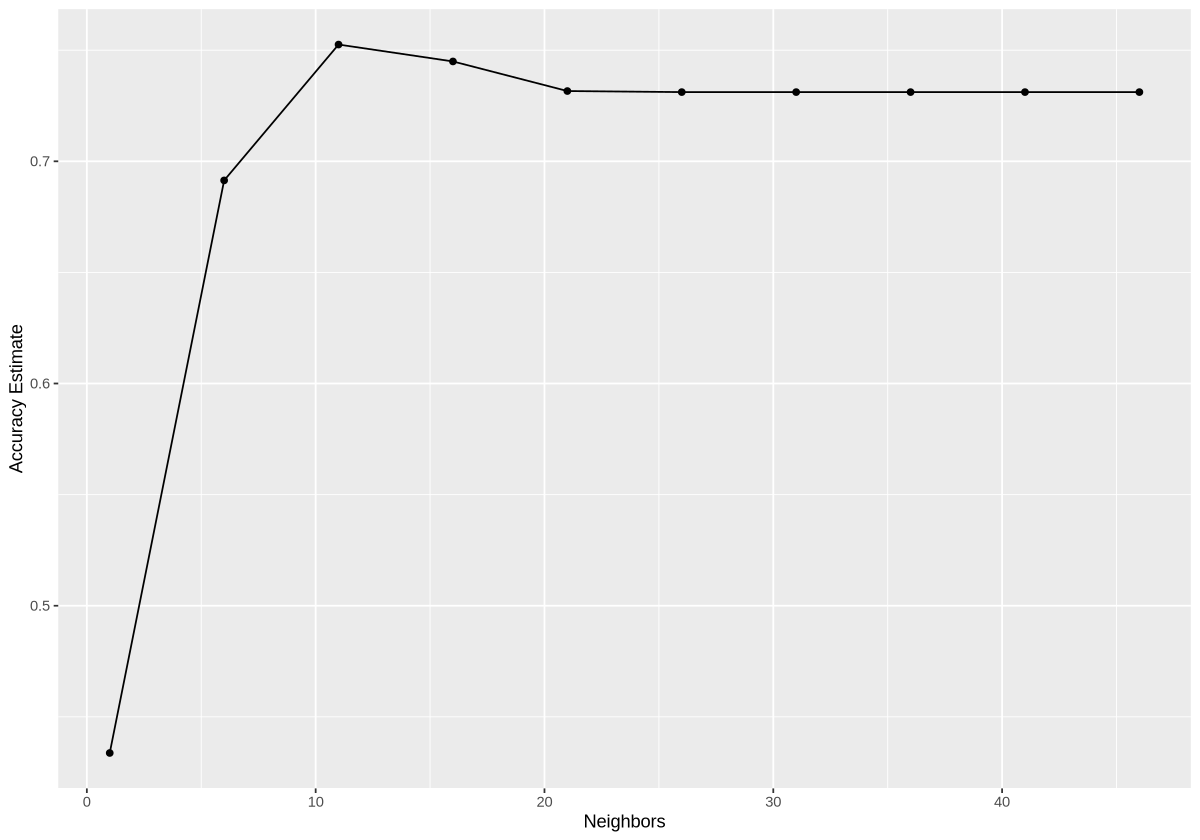

In [47]:
options(warn = 0)
options(repr.plot.height = 7, repr.plot.width = 10)
knn_results <- workflow() |> 
       add_recipe(player_recipe) |>
       add_model(knn_tune) |>
       tune_grid(resamples = player_vfold, grid = k_vals) |>
       collect_metrics()
knn_results

accuracy <- knn_results|>
    filter(.metric == "accuracy")

accuracy_vs_k <- ggplot(accuracy, aes(x = neighbors, y = mean))+
       geom_point() +
       geom_line() +
       labs(x = "Neighbors", y = "Accuracy Estimate") 
      # scale_x_continuous(breaks = seq(0, 14, by = 1)) +  # adjusting the x-axis
      # scale_y_continuous(limits = c(0.4, 1.0)) # adjusting the y-axis
accuracy_vs_k

In [48]:
best_k <- accuracy |>
        arrange(desc(mean)) |>
        head(1) |>
        pull(neighbors)
best_k

[1] 11

In [53]:
best_player_recipe <- recipe(subscribe ~ Age + played_hours + gender, data = player_train) |>
  step_scale(all_predictors()) |>
  step_center(all_predictors())

knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = best_k) |>
  set_engine("kknn") |>
  set_mode("classification")

knn_fit <- workflow() |>
  add_recipe(best_player_recipe) |>
  add_model(knn_spec) |>
  fit(data = player_train)

knn_fit

player_test_predictions <- predict(knn_fit, player_test) |>
  bind_cols(player_test)

player_test_predictions |>
  metrics(truth = subscribe, estimate = .pred_class) |>
  filter(.metric == "accuracy")

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_scale()
• step_center()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(11,     data, 5), kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.2344828
Best kernel: rectangular
Best k: 11

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.6122449


In [54]:
confusion <- player_test_predictions |>
             conf_mat(truth = subscribe, estimate = .pred_class)
confusion

          Truth
Prediction FALSE TRUE
     FALSE     1    7
     TRUE     12   29